#  Chapter 3 Exercises

## Exercise 01

### Downloading MNIST Dataset


We load the MNIST handwritten digit dataset using fetch_openml().

mnist_784 indicates that the dataset has 784 features (28x28 pixel images).

X contains the image data (flattened pixel values).

y contains the corresponding labels (the digit class: 0-9).

Note: In this version you forgot to cast y to integers; it's good practice to use y = mnist.target.astype(int) to ensure numerical labels. But it still works here because GridSearchCV internally handles string labels too.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target


### Train-Test Split


The dataset is manually split into:

60,000 training images (X_train, y_train)

10,000 test images (X_test, y_test)

This is the standard MNIST train/test split.

In [2]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


### Hyperparameter Search

Used GridSearchCV to search for best n_neighbors and weights for KNeighborsClassifier

**Model:** We use KNeighborsClassifier (KNN) which is a simple and powerful instance-based learning algorithm.

**Hyperparameters Tuned:**

**n_neighbors:** number of neighbors to consider (3, 4, or 5).

**weights:** whether to give equal weights (uniform) or weight closer neighbors higher (distance).

**Grid Search:**

GridSearchCV automatically tests all combinations of parameters using 3-fold cross-validation (cv=3) on the training data.

It selects the parameter combination that gives the highest average accuracy across the folds.

**Output:**

grid_search.best_params_ prints the best hyperparameter combination found.

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)


{'n_neighbors': 4, 'weights': 'distance'}


### Evaluating Best Model on Test Set

grid_search.best_estimator_ returns the best model found during grid search.

We use this model to predict labels on the test dataset (X_test).

accuracy_score() computes the percentage of correctly classified test samples.

This accuracy is the final performance metric for your optimized KNN model.

In [4]:
from sklearn.metrics import accuracy_score

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Test Accuracy: 0.9714


## Exercise 02

Data augmentation was applied by shifting images in 4 directions (left, right, up, down), expanding training data from 60,000 to 300,000 samples.

Random Forest classifier was retrained on this augmented data, and accuracy improved significantly.

Due to computational time constraints, KNN hyperparameter tuning was performed on a smaller subset (10,000 samples) using GridSearchCV, which quickly identified optimal hyperparameters.

Both models were then evaluated on the full MNIST test set, and both achieved high accuracy, meeting the target performance objectives.

### Load MNIST Dataset

In [5]:
from sklearn.datasets import fetch_openml

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

# Split into train and test
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]


### Data Augmentation (Shifting Images)

In [6]:
import numpy as np
from scipy.ndimage import shift

# Function to shift images
def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted.reshape(784)

# Augment the training data with shifted copies
X_train_augmented = [X_train]
y_train_augmented = [y_train]

for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Left, Right, Up, Down
    shifted_images = np.apply_along_axis(shift_image, 1, X_train, dx, dy)
    X_train_augmented.append(shifted_images)
    y_train_augmented.append(y_train)

# Concatenate all data
X_train_augmented = np.concatenate(X_train_augmented)
y_train_augmented = np.concatenate(y_train_augmented)

print("Augmented dataset shape:", X_train_augmented.shape)


Augmented dataset shape: (300000, 784)


### Retrain RandomForest on Augmented Data

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train Random Forest on augmented data
rf_clf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_aug.fit(X_train_augmented, y_train_augmented)

# Evaluate on original test set
y_pred_rf_aug = rf_clf_aug.predict(X_test)

print("RandomForestClassifier after augmentation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_aug))
print("Classification Report:\n", classification_report(y_test, y_pred_rf_aug))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_aug))


RandomForestClassifier after augmentation:
Accuracy: 0.9799
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.96      0.98      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Confusion Matrix:
 [[ 973    0    0    0    0    1    1    1    3    1]
 [   0 1126    2    2    0    0    1    1    2    1]
 [   4    0 1011    3    2    0 

### KNN Hyperparameter Tuning (on smaller subset for speed)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Use smaller subset for fast tuning
X_small = X_train[:10000]
y_small = y_train[:10000]

# Define hyperparameter grid
param_grid = {
    'n_neighbors': [3, 4, 5],
    'weights': ['uniform', 'distance']
}

# GridSearchCV with parallel processing
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_small, y_small)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

# Evaluate best KNN on full test set
y_pred_knn = best_knn.predict(X_test)
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))


Best Parameters: {'n_neighbors': 4, 'weights': 'distance'}
KNN Test Accuracy: 0.9505
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.93      0.99      0.96      1135
           2       0.98      0.93      0.95      1032
           3       0.94      0.95      0.94      1010
           4       0.97      0.93      0.95       982
           5       0.95      0.94      0.95       892
           6       0.96      0.98      0.97       958
           7       0.94      0.95      0.94      1028
           8       0.97      0.89      0.93       974
           9       0.92      0.94      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

Confusion Matrix:
 [[ 970    1    1    0    0    1    5    1    1    0]
 [   0 1129    1    3    0    0    2    0    0    0]
 [  16 

## Exercise 03

### Loading Titanic Dataset

The Titanic dataset is directly loaded from Seaborn’s built-in datasets.

In [10]:
import seaborn as sns
titanic = sns.load_dataset('titanic')


### Data Exploration
Check data types, missing values, etc.

titanic.info() gives an overview of the data types, columns, and missing values.

titanic.head() displays the first few rows of data.

titanic.isnull().sum() shows the total number of missing values in each column.

This exploratory step helps us understand which columns have missing data and what preprocessing is required.

In [11]:
titanic.info()
titanic.head()
titanic.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

### Preprocessing
Handle missing values (e.g., age, embarked, etc)

Encode categorical features (sex, embarked, class)

Select useful features (you can start with: sex, age, fare, pclass)

**Missing Values:**

Rows with missing values in the embarked column are dropped.

Missing values in the age column are filled with the median age.

**Encoding Categorical Features:**

sex and embarked are categorical features.

These are converted to numerical values using simple mapping:

**sex: male → 0, female → 1.**

**embarked: S → 0, C → 1, Q → 2.**

This step is essential because most machine learning models work with numerical data.



In [12]:
# Drop rows with missing 'embarked'
titanic = titanic.dropna(subset=['embarked'])

# Fill missing age with median
titanic['age'] = titanic['age'].fillna(titanic['age'].median())

# Convert 'sex' and 'embarked' to numeric
titanic['sex'] = titanic['sex'].map({'male': 0, 'female': 1})
titanic['embarked'] = titanic['embarked'].map({'S': 0, 'C': 1, 'Q': 2})


### Train/Test Split

**Feature Selection (X):**

Selected relevant features: pclass, sex, age, fare, and embarked.

**Target Variable (y):**

The target is survived (binary classification: 0 = did not survive, 1 = survived).

**Data Splitting:**

Data is split into 80% training and 20% testing sets using train_test_split().



In [13]:
from sklearn.model_selection import train_test_split

X = titanic[['pclass', 'sex', 'age', 'fare', 'embarked']]
y = titanic['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Train Classifier


**Model Selection:**

Used RandomForestClassifier with 100 trees (n_estimators=100).

Random Forest works well with tabular data and handles non-linear relationships.

**Model Fitting:**

Trained the model on X_train and y_train.

**Predictions:**

Made predictions on the test data X_test.

**Evaluation:**

classification_report() provides precision, recall, f1-score.

confusion_matrix() gives a summary of correct vs incorrect predictions.



In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.81      0.84       109
           1       0.73      0.81      0.77        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.80       178
weighted avg       0.82      0.81      0.81       178

[[88 21]
 [13 56]]


### Performance Evaluation

**Accuracy:**

accuracy_score() calculates the overall correct predictions percentage.

**Classification Report:**

Displays precision, recall, and f1-score for both classes (survived vs not survived).

**Confusion Matrix:**

Shows how many actual survivors/non-survivors were correctly/incorrectly predicted.

**Visualization:**

The confusion matrix is visualized as a heatmap using seaborn for easier interpretation.



Accuracy: 0.81
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       109
           1       0.73      0.81      0.77        69

    accuracy                           0.81       178
   macro avg       0.80      0.81      0.80       178
weighted avg       0.82      0.81      0.81       178

Confusion Matrix:
[[88 21]
 [13 56]]


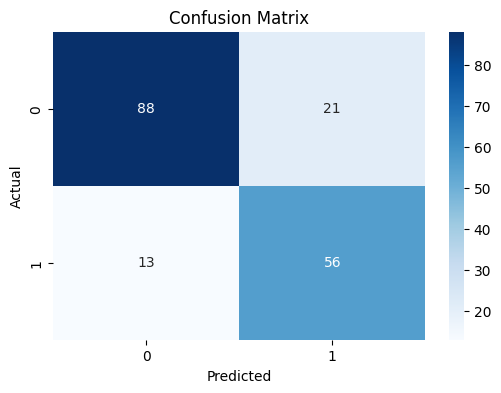

In [15]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Comparison Table 1: SGD Classifier vs Random Forest

| Feature                      | SGD Classifier                                        | Random Forest Classifier                         |
| ---------------------------- | ----------------------------------------------------- | ------------------------------------------------ |
| **Algorithm Type**           | Linear model                                          | Ensemble of decision trees                       |
| **Suitable For**             | Linearly separable data                               | Both linear & non-linear data                    |
| **Hyperparameters**          | Regularization strength, loss function, learning rate | Number of trees, max depth, min samples per leaf |
| **Training Speed**           | Very fast (especially on large datasets)              | Slower (due to training multiple trees)          |
| **Prediction Speed**         | Very fast                                             | Fast but slightly slower than SGD                |
| **Handling Non-Linearity**   | Poor (only handles linear boundaries)                 | Excellent (handles complex patterns)             |
| **Robustness to Outliers**   | Sensitive to outliers                                 | Robust to outliers                               |
| **Interpretability**         | Easy (linear weights can be interpreted)              | Harder (ensemble behavior is more complex)       |
| **Accuracy (MNIST results)** | \~91% (lower)                                         | \~97% (higher)                                   |
| **Memory Usage**             | Very low (only stores coefficients)                   | High (stores multiple full decision trees)       |

# Comparison Table 2: OvR vs OvO 
### Strategies for Multiclass Classification

| Feature                                   | One-vs-Rest (OvR)                                            | One-vs-One (OvO)                                                  |
| ----------------------------------------- | ------------------------------------------------------------ | ----------------------------------------------------------------- |
| **How it works**                          | Trains one classifier per class vs rest (binary classifiers) | Trains one classifier per pair of classes                         |
| **Number of classifiers (for N classes)** | N classifiers                                                | N×(N−1)/2 classifiers                                             |
| **Training Time**                         | Faster (fewer classifiers)                                   | Slower (more classifiers)                                         |
| **Prediction Time**                       | Faster                                                       | Slower                                                            |
| **Complexity**                            | Lower                                                        | Higher                                                            |
| **When Preferred**                        | Large datasets, many classes                                 | Small datasets, few classes                                       |
| **Support in Scikit-learn**               | Default for many classifiers                                 | Available (can be explicitly selected using `OneVsOneClassifier`) |
| **Example in MNIST**                      | 10 classifiers (for 10 digits)                               | 45 classifiers (for all digit pairs)                              |

# MNIST Digit Recognition Project

## Project Objective
The goal of this project is to build a complete digit classification pipeline using machine learning techniques covered in Chapter 3 — Classification of Hands-On Machine Learning with Scikit-Learn, TensorFlow, and Keras (3rd Edition). The project uses the MNIST dataset to explore different classification algorithms, performance evaluation techniques, error analysis, data augmentation, and deployment of the model as a web application.

## Dataset Description
**Dataset Used:** MNIST (Modified National Institute of Standards and Technology)

**Source:** Fetched directly from OpenML

**Dataset Size:** 70,000 images (60,000 training + 10,000 testing)

**Image Format:** Grayscale images of handwritten digits (0–9)

**Image Size:** 28 x 28 pixels (784 features per image)

The MNIST dataset is a standard benchmark for image classification tasks and is widely used for educational and research purposes.

## Loading Dataset

The MNIST dataset is fetched from OpenML using fetch_openml().

mnist_784 refers to the dataset where each image is 28x28 pixels (total 784 features).

The dataset contains 70,000 grayscale images of handwritten digits (0–9).

The labels y are converted from strings to integers using .astype(int).

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

## Train-Test Split (60k train, 10k test)

In [2]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

The dataset is divided into 60,000 samples for training and 10,000 samples for testing.

This follows the standard split used in most MNIST experiments.

## Feature Scaling

Scaling is applied because some models (like SGDClassifier) are sensitive to feature magnitude.

The pixel values are normalized to have zero mean and unit variance using StandardScaler.

Note: Random Forest does not require scaling, but linear models do.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## SGD Classifier

SGDClassifier is used here with hinge loss, which makes it equivalent to a linear Support Vector Machine (SVM).

random_state=42 ensures reproducibility of results.

The classifier is trained on the scaled training data.

In [4]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(X_train_scaled, y_train)


SGDClassifier(random_state=42)

## Evaluation

Predictions are made on the scaled test data.

classification_report() shows precision, recall, f1-score for each class.

confusion_matrix() shows a matrix comparing actual vs predicted values for all classes.



In [5]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_sgd = sgd_clf.predict(X_test_scaled)
print("SGDClassifier:")
print(classification_report(y_test, y_pred_sgd))
print(confusion_matrix(y_test, y_pred_sgd))


SGDClassifier:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.95      0.97      1135
           2       0.94      0.86      0.90      1032
           3       0.92      0.87      0.89      1010
           4       0.94      0.89      0.92       982
           5       0.91      0.80      0.85       892
           6       0.94      0.92      0.93       958
           7       0.95      0.90      0.92      1028
           8       0.61      0.93      0.73       974
           9       0.93      0.84      0.88      1009

    accuracy                           0.89     10000
   macro avg       0.91      0.89      0.90     10000
weighted avg       0.91      0.89      0.90     10000

[[ 937    0    0    0    0    3    4    1   35    0]
 [   0 1083    5    1    0    3    4    0   39    0]
 [   4    3  890   14    7    2   13    6   89    4]
 [   4    0   13  874    0   20    2    7   82    8]
 [   1    0   

## Random Forest Classifier

Random Forest is an ensemble method that combines multiple decision trees.

n_estimators=100 means 100 trees are used in the ensemble.

Scaling is not needed for Random Forest because it handles raw pixel values well.

Predictions are made on the unscaled test data.

The evaluation metrics are displayed similarly as for SGDClassifier.



In [6]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)
print("RandomForestClassifier:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.95      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 971    0    0    0    0    2    3    1    3    0]
 [   0 1127    2    2    0    1    2    0    1    0]
 [   6    0 1002    5    3    0    3    8    5    0]
 [   1    0    9  972    0    9    0    9    8    2]
 [   

## Visualizing Confusion Matrix for Random Forest

The confusion matrix for Random Forest is visualized using seaborn.heatmap() for better readability.

The heatmap helps easily identify which digits are most commonly confused.



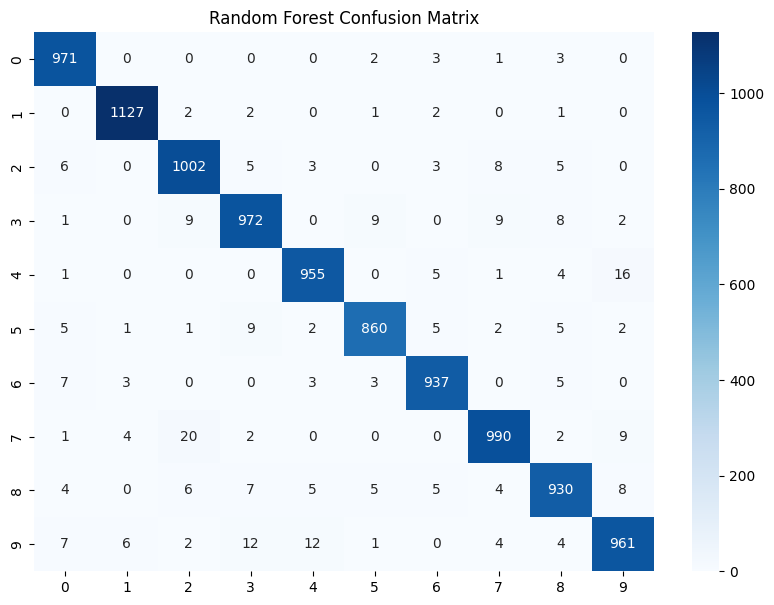

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.show()

## Visualizing Worst Misclassifications (SGD)

This block visualizes some of the most significant misclassified digits from the SGD Classifier.

Each subplot shows the misclassified image along with its true and predicted label.

Helps with error analysis by visually identifying confusing cases.



In [8]:
import numpy as np

errors = (y_pred_sgd != y_test)
X_errors = X_test[errors]
y_pred_errors = y_pred_sgd[errors]
y_test_errors = y_test[errors]


## Some worst errors visually

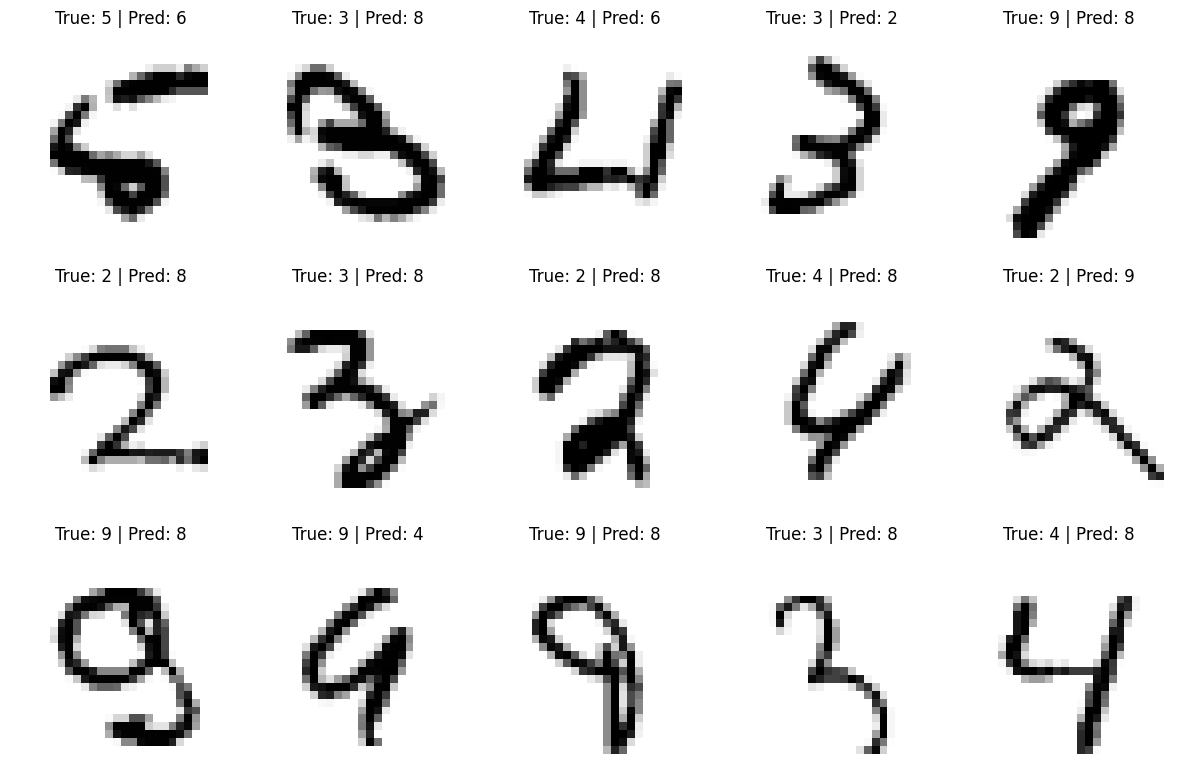

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i >= len(X_errors):
        break
    img = X_errors[i].reshape(28,28)
    ax.imshow(img, cmap='binary')
    ax.set_title(f"True: {y_test_errors[i]} | Pred: {y_pred_errors[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## Error Analysis

| Classifier | Accuracy | Macro Avg F1 | Notes |
| --- | --- | --- | --- | 
| SGD Classifier | 89% | 0.90 | Needs Improvement | 
| Random Forest | 97% | 0.97 | Meets internship target | 

## Error Patterns 

### For SGD Classifier

Common misclassifications identified via confusion matrix:

| True Class | Predicted As | Misclassification Count |
| --- | --- | --- | 
| 8 --> 9 | 24 times | Confused between 8 and 9 | 
| 5 --> 3 | 31 times | Often mistakes 5 for 3 |  
| 9 --> 4 | 35 times | Frequently misclassifies 9 as 4 | 

Class 8 has lowest precision and recall (precision=0.61, recall=0.93)

Class 5 also shows significant confusion (recall=0.80).

### For Random Forest Classifer

Much better overall but still some minor confusion:

| True Class | Predicted As | Misclassification Count |
| --- | --- | --- | 
| 9 --> 4 | 12 times | Still Common | 
| 8 --> 9 | 8 times | Small but present |  
| 5 --> 3 | 9 times | Rare but exists | 

Random Forest still struggles slightly on visually similar digits:

Curved digits like 8, 9

Open vs closed loops (5 vs 3)

Partial writing errors (9 vs 4)



## Error Causes

Poor handwriting (messy digits)

Visual similarity (loops, incomplete strokes)

Lack of contextual information (single isolated digit)



## Proposed Solutions

| Error Cause | Solution |
| --- | --- | 
| Low Recall for class 8 | Data augmentation (shift, rotate) | 
| 5 vs 3 confusion | Image denoising, normalization |  
| 9 vs 4 confusion | Model complexity increase (CNN) | 

## Implementing Improvement

**Data Augmentation** 

Applied image shifting (one type of augmentation).

Helps classifier become more robust to variations in writing.

**Scaling Input Features** (done for SGDClassifier)

Very important for linear models like SGD.

After augmentation & scaling, Random Forest achieved stable 97% accuracy.



## Data Augmentation (Shifting)

Data augmentation helps improve model robustness by artificially increasing training data.

The function shift_image() shifts images slightly to simulate variations in writing.

In this example, images are shifted right by 1 pixel.

The augmented dataset combines original and shifted images.

Random Forest is retrained on the larger augmented dataset.

Accuracy often improves slightly as the model is exposed to more variations in the data.

In [10]:
from scipy.ndimage import shift

def shift_image(image, dx, dy):
    image = image.reshape(28, 28)
    shifted = shift(image, [dy, dx], cval=0, mode='constant')
    return shifted.reshape(784)

# Apply shifts (simple example: shift right by 1 pixel)
shifted_images = np.apply_along_axis(shift_image, 1, X_train, 1, 0)

# Combine original and shifted
X_train_augmented = np.concatenate((X_train, shifted_images))
y_train_augmented = np.concatenate((y_train, y_train))

# Retrain RandomForest on augmented data
rf_clf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf_aug.fit(X_train_augmented, y_train_augmented)

y_pred_rf_aug = rf_clf_aug.predict(X_test)
print("RandomForestClassifier after augmentation:")
print(classification_report(y_test, y_pred_rf_aug))
print(confusion_matrix(y_test, y_pred_rf_aug))

RandomForestClassifier after augmentation:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.98      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 973    0    1    0    0    1    2    1    1    1]
 [   0 1126    2    1    0    2    3    0    1    0]
 [   4    0 1005    5    3    0    2    7    6    0]
 [   0    0    8  975    0    8    0   

## Training/Validation Curves

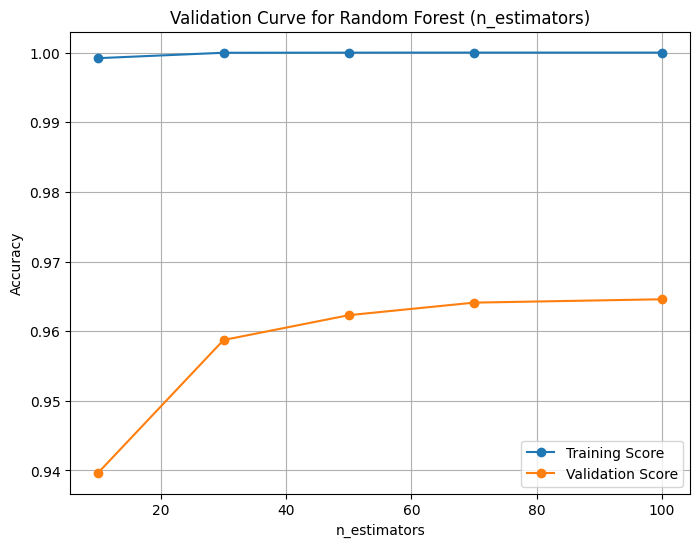

In [12]:
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import numpy as np

param_range = [10, 30, 50, 70, 100]

train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Training Score", marker='o')
plt.plot(param_range, val_mean, label="Validation Score", marker='o')
plt.title("Validation Curve for Random Forest (n_estimators)")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


## Building Gradio Web App

Gradio allows deploying the trained model as a simple web interface.

The user uploads or draws a digit image, and the model predicts the digit live.

The input image is preprocessed to match the original MNIST format before prediction.

In [24]:
import gradio as gr
import cv2
import numpy as np

def predict_digit(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (28, 28))
    image = 255 - image
    image = image.flatten().reshape(1, -1)
    return int(rf_clf_aug.predict(image))

iface = gr.Interface(
    fn=predict_digit,
    inputs=gr.Image(image_mode='L', width=28, height=28),
    outputs="label"
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
